# Enriched flagellins across biomes

This notebook will focus on phylogenetic analyses with differentially abundant (DA) flagellins previously identified between host-associated and free-living environments

### Set-up

In [35]:
library(tidyverse)
library(ggplot2)
library(ggsci)
library(viridis)
library(conflicted)
library(gridExtra)
library(vegan)
library(ape)
library(lattice)
library(permute)
library(grid) 
library(seqinr)
library("picante")
library("phylosignal")
library("phytools")
library(rentrez)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:seqinr’:

    gls


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:viridis’:

    unemp


The following object is masked from ‘package:purrr’:

    map




In [36]:
conflict_prefer("filter","dplyr")
conflict_prefer("rename","dplyr")
conflict_prefer("mutate","dplyr")
conflict_prefer("count","dplyr")

[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::filter over any other package
[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::rename over any other package
[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::mutate over any other package
[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::count over any other package


In [3]:
setwd("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/shortbred/edgeR")

### Import input files

## Non-rarefied / filtered results

In [193]:
#EdgeR results
DA.animals.env = read_tsv("DA.animals.env.nonrare.filt.tsv",col_names=T)
DA.animals.plants = read_tsv("DA.animalvsplant.nonrare.filt.tsv",col_names=T)
DA.plants.env = read_tsv("DA.plants.env.nonrare.filt.tsv",col_names=T)
DA.host.env = read_tsv("DA.biome1.nonrare.filt.tsv",col_names=T)

Rows: 836 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Accession, Domain, Phylum, Class, Order, Family, Genus, Species
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 353 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Accession, Domain, Phylum, Class, Order, Family, Genus, Species
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 277 Columns: 12
── Column specification ────────────────────────────────────────────────

In [194]:
#Flagellin multifasta
flagellins.markers.sb=seqinr::read.fasta("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/out.finalmap.faa",seqtype="AA")

In [111]:
flagellin.sizes.taxonomy = read_tsv("flagellin.lengths.taxonomy.tsv",col_names=T) %>%
select(Accession,HVR_length,ncbi_phylum,genome_size)

Rows: 9963 Columns: 14
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Accession, flaID, ncbi_phylum, Domain, Phylum, Class, Order, Famil...
dbl  (4): length, HVR_length, ncbi_taxid, genome_size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [195]:
#Filter sequences for each set of DA flagellins
seqs.DA.animals.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.env$Accession))]
seqs.DA.animals.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.plants$Accession))]
seqs.DA.plants.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.plants.env$Accession))]
seqs.DA.host.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.host.env$Accession))]

In [30]:
#Export sequences
write.fasta(sequences = seqs.DA.animals.env, names = names(seqs.DA.animals.env), nbchar = 80, file.out = "seqs.DA.animals.env.faa")
write.fasta(sequences = seqs.DA.animals.plants, names = names(seqs.DA.animals.plants), nbchar = 80, file.out = "seqs.DA.animals.plants.faa")
write.fasta(sequences = seqs.DA.plants.env, names = names(seqs.DA.plants.env), nbchar = 80, file.out = "seqs.DA.plants.env.faa")
write.fasta(sequences = seqs.DA.host.env, names = names(seqs.DA.host.env), nbchar = 80, file.out = "seqs.DA.host.env.faa")


In [196]:
names(DA.animals.env)

[1] "Accession" "Domain"    "Phylum"    "Class"     "Order"     "Family"   
 [7] "Genus"     "Species"   "logFC"     "logCPM"    "PValue"    "FDR"

In [112]:
map.DA.animals.env = mutate(DA.animals.env,Enriched_in=ifelse(logFC<0,"Animal","Environmental"))%>%
inner_join(flagellin.sizes.taxonomy,by="Accession")

In [184]:
head(map.DA.animals.env)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,Enriched_in,HVR_length,ncbi_phylum,genome_size
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.232739,11.23077,3.571169e-170,5.192480e-167,Environmental,431,Proteobacteria,1652246
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.681773,11.22161,2.217910e-140,1.612420e-137,Environmental,329,Proteobacteria,4456718
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,2.805084,11.85580,1.167445e-135,5.658215e-133,Environmental,271,Actinobacteria,2435166
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.110978,14.10823,7.244926e-106,2.633531e-103,Environmental,186,Proteobacteria,7666841
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.550352,10.96537,1.394940e-103,4.056485e-101,Environmental,34,Proteobacteria,8193889
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.344626,11.36667,7.013927e-99,1.699708e-96,Environmental,266,Proteobacteria,5876049


In [197]:
#Create mapping files
map.DA.animals.env = mutate(DA.animals.env,Enriched_in=ifelse(logFC<0,"Animal","Environmental"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.animals.plants = mutate(DA.animals.plants,Enriched_in=ifelse(logFC<0,"Animal","Plants"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.plants.env = mutate(DA.plants.env,Enriched_in=ifelse(logFC<0,"Environmental","Plants"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.host.env = mutate(DA.host.env,Enriched_in=ifelse(logFC<0,"Environmental","Host"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

In [115]:
#Write mapping files
write_tsv(map.DA.animals.env,"map.DA.animals.env.tsv")
write_tsv(map.DA.animals.plants,"map.DA.animals.plants.tsv")
write_tsv(map.DA.plants.env,"map.DA.plants.env.tsv")
write_tsv(map.DA.host.env,"map.DA.host.env.tsv")

In [198]:
#Count the number of enriched flagellins per pairwise group-comparison
dplyr::count(map.DA.animals.env,Enriched_in)
dplyr::count(map.DA.animals.plants,Enriched_in)
dplyr::count(map.DA.plants.env,Enriched_in)
dplyr::count(map.DA.host.env,Enriched_in)

Enriched_in,n
<chr>,<int>
Animal,312
Environmental,524


Enriched_in,n
<chr>,<int>
Animal,294
Plants,59


Enriched_in,n
<chr>,<int>
Environmental,260
Plants,17


Enriched_in,n
<chr>,<int>
Environmental,533
Host,284


## Rarefied / filtered results

In [9]:
#EdgeR results
DA.animals.env.rare = read_tsv("DA.animals.env.rare.filt.tsv",col_names=T)
DA.animals.plants.rare = read_tsv("DA.animalvsplant.rare.filt.tsv",col_names=T)
DA.plants.env.rare = read_tsv("DA.plants.env.rare.filt.tsv",col_names=T)
DA.host.env.rare = read_tsv("DA.host.env.rare.filt.tsv",col_names=T)

Rows: 95 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Accession, Domain, Phylum, Class, Order, Family, Genus, Species
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 83 Columns: 12
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Accession, Domain, Phylum, Class, Order, Family, Genus, Species
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 7 Columns: 12
── Column specification ────────────────────────────────────────────────────

In [10]:
head(DA.animals.env.rare)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,2.119438,14.15174,3.104126e-26,2.175992e-23
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,1.500100,12.26035,5.894436e-20,1.679125e-17
RHP37040.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565,-2.775440,12.98752,7.185984e-20,1.679125e-17
EFZ33846.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Ligilactobacillus,s__Ligilactobacillus ruminis,-3.815614,13.79856,2.957759e-14,5.183473e-12
SJZ39514.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D porcinum,-2.333186,12.91232,4.604290e-14,6.455215e-12
WP_022931566.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D bryantii_C,-2.142652,12.66159,8.988289e-13,1.050132e-10


### Filter sequences

In [11]:
#Filter sequences
seqs.DA.animals.env.rare = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.env.rare$Accession))]
seqs.DA.animals.plants.rare = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.plants.rare$Accession))]
seqs.DA.plants.env.rare = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.plants.env.rare$Accession))]
seqs.DA.host.env.rare = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.host.env.rare$Accession))]

In [65]:
#Write multifasta with subsets of sequences
write.fasta(sequences = seqs.DA.animals.env.rare, names = names(seqs.DA.animals.env.rare), nbchar = 80, file.out = "seqs.DA.animals.env.rare.faa")
write.fasta(sequences = seqs.DA.animals.plants.rare, names = names(seqs.DA.animals.plants.rare), nbchar = 80, file.out = "seqs.DA.animals.plants.rare.faa")
write.fasta(sequences = seqs.DA.plants.env.rare, names = names(seqs.DA.plants.env.rare), nbchar = 80, file.out = "seqs.DA.plants.env.rare.faa")
write.fasta(sequences = seqs.DA.host.env.rare, names = names(seqs.DA.host.env.rare), nbchar = 80, file.out = "seqs.DA.host.env.rare.faa")


In [116]:
#Create mapping files
map.DA.animals.env.rare = mutate(DA.animals.env.rare,Enriched_in=ifelse(logFC<0,"Animal","Environmental"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.animals.plants.rare = mutate(DA.animals.plants.rare,Enriched_in=ifelse(logFC<0,"Animal","Plants"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.plants.env.rare = mutate(DA.plants.env.rare,Enriched_in=ifelse(logFC<0,"Environmental","Plants"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")
map.DA.host.env.rare = mutate(DA.host.env.rare,Enriched_in=ifelse(logFC<0,"Environmental","Host"))%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

In [186]:
#Summarize counts of enriched flagellind
dplyr::count(map.DA.animals.env.rare,Enriched_in)
dplyr::count(map.DA.animals.plants.rare,Enriched_in)
dplyr::count(map.DA.plants.env.rare,Enriched_in)
dplyr::count(map.DA.host.env.rare,Enriched_in)

Enriched_in,n
<chr>,<int>
Animal,68
Environmental,27


Enriched_in,n
<chr>,<int>
Animal,38
Plants,45


Enriched_in,n
<chr>,<int>
Environmental,2
Plants,5


Enriched_in,n
<chr>,<int>
Environmental,48
Host,118


In [117]:
#Export mapping table 
write_tsv(map.DA.animals.env.rare,"map.DA.animals.env.rare.tsv")
write_tsv(map.DA.animals.plants.rare,"map.DA.animals.plants.rare.tsv")
write_tsv(map.DA.plants.env.rare,"map.DA.plants.env.rare.tsv")
write_tsv(map.DA.host.env.rare,"map.DA.host.env.rare.tsv")

In [154]:
nrow(map.DA.animals.plants.rare)
nrow(map.DA.animals.plants)

[1] 83

[1] 353

In [171]:
#Flagellins only in rarefied list, and absent in non-rarefied list
#These flagellins do not overlap with flagellins from non-rarefied analysis
DA.animals.plants = mutate(map.DA.animals.plants.rare,InNonRarefied=if_else(Accession%in%map.DA.animals.plants$Accession,1,0))%>%
filter(InNonRarefied==0)
#sum(if_else(map.DA.animals.env.rare$Accession%in%map.DA.animals.plants$Accession,1,0))

In [188]:
count(map.DA.animals.plants,Species)

Species,n
<chr>,<int>
s__14-2 sp000403315,1
s__14-2 sp001940225,1
s__Acetatifactor muris,2
s__Acetatifactor sp900066365,2
s__Acetatifactor sp900066565,2
s__Achromobacter xylosoxidans,4
s__Aeromonas caviae,1
s__Aeromonas hydrophila,1
s__Aeromonas schubertii,1


## Define the two datasets

In [199]:
DA.animals = filter(map.DA.animals.plants,Enriched_in=="Animal")
DA.plants = filter(map.DA.animals.plants,Enriched_in=="Plants")
DA.env = filter(map.DA.host.env,Enriched_in=="Environmental")
DA.host = filter(map.DA.host.env,Enriched_in=="Host")

In [202]:
#Write datasets of flagellins enriched in each biome
write_tsv(DA.animals,"DA.animals.tsv")
write_tsv(DA.plants,"DA.plants.tsv")
write_tsv(DA.env,"DA.env.tsv")
write_tsv(DA.host,"DA.host.tsv")

In [200]:
nrow(DA.animals)
nrow(DA.plants)
nrow(DA.env)
nrow(DA.host)

[1] 294

[1] 59

[1] 533

[1] 284

In [122]:
#Define the datasets
set.animals=DA.animals
set.plants=DA.plants
set.env=DA.env
set.host=DA.host
set.all=read.delim("flags.tax.nonrareAll.tsv")%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

##### Import phylogeny

In [38]:
#Import full set phylogeny

tre.all=read.tree("flags.nonrareAll.tre")
phy=midpoint.root(tre.all)
tre.all

##### Create traits dataframe

In [125]:
#Create traits dataframe
traits.enriched= set.all %>% 
    mutate(enriched.animals=if_else(tre.all$tip.label%in%set.animals$Accession,1,0))%>%
    mutate(enriched.plants=if_else(tre.all$tip.label%in%set.plants$Accession,1,0))%>%
    mutate(enriched.env=if_else(tre.all$tip.label%in%set.env$Accession,1,0))%>%
    mutate(enriched.host=if_else(tre.all$tip.label%in%set.host$Accession,1,0))%>%
    select(Accession,enriched.animals,enriched.plants,enriched.env,enriched.host,HVR_length,genome_size)

head(traits.enriched)

,Accession,enriched.animals,enriched.plants,enriched.env,enriched.host,HVR_length,genome_size
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WP_018305791.1,0,0,1,0,142,5666696
2,KJS48310.1,0,0,1,0,913,6027195
3,OBW58796.1,0,0,0,0,149,4179438
4,ESU34160.1,0,0,0,0,215,4696869
5,KMY55506.1,0,0,0,0,89,4332205
6,WP_087615600.1,0,0,0,0,263,3809180


##### Create trait list for phylosignal object

In [126]:
#Create trait list for phylosignal object
dat <- list()
dat$enriched.animals <- traits.enriched$enriched.animals
dat$enriched.plants <- traits.enriched$enriched.plants
dat$enriched.env <- traits.enriched$enriched.env
dat$enriched.host <- traits.enriched$enriched.host
dat$HVR_length <- traits.enriched$HVR_length
dat$genome_size <- traits.enriched$genome_size
dat <- as.data.frame(dat)
rownames(dat) = traits.enriched$Accession
head(dat)

,enriched.animals,enriched.plants,enriched.env,enriched.host,HVR_length,genome_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,1,0,142,5666696
KJS48310.1,0,0,1,0,913,6027195
OBW58796.1,0,0,0,0,149,4179438
ESU34160.1,0,0,0,0,215,4696869
KMY55506.1,0,0,0,0,89,4332205
WP_087615600.1,0,0,0,0,263,3809180


In [49]:
nrow(dat)

[1] 1454

##### Create phylosignal object

In [127]:
#Create phylosignal object
p4d <- phylobase::phylo4d(phy, dat)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


##### Testing phylosignal

In [130]:
#Test phylosignal hypothesis using Pagel's Lambda method for categorical traits
phylosignal.finalset=phyloSignal(p4d,methods=c("Lambda","Cmean"))
phylosignal.finalset

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


,Cmean,Lambda
,<dbl>,<dbl>
enriched.animals,0.3989167,0.4336678
enriched.plants,0.2160715,0.5589629
enriched.env,0.3202578,0.7070290
enriched.host,0.4284080,0.4404243
HVR_length,0.5405331,1.0345197
genome_size,0.5808978,1.0199893
,Cmean,Lambda
,<dbl>,<dbl>
enriched.animals,0.001,0.001


In [131]:
flag.lipa <- lipaMoran(p4d)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in .local(x, ...):
“Non-unique or missing labels found, labels cannot be coerced to tdata row.names. Use the label.type argument to include labels as first column of data.”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in matrix(x, nrow = n.tips, ncol = n.traits):
“data length differs from size of matrix: [8724 != 1454 x 1]”
Warning message in plot.window(...):
“"label.type" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"label.type" is not a graphical parameter”
Warning message in title(...):
“"label.type" is not a graphical parameter”


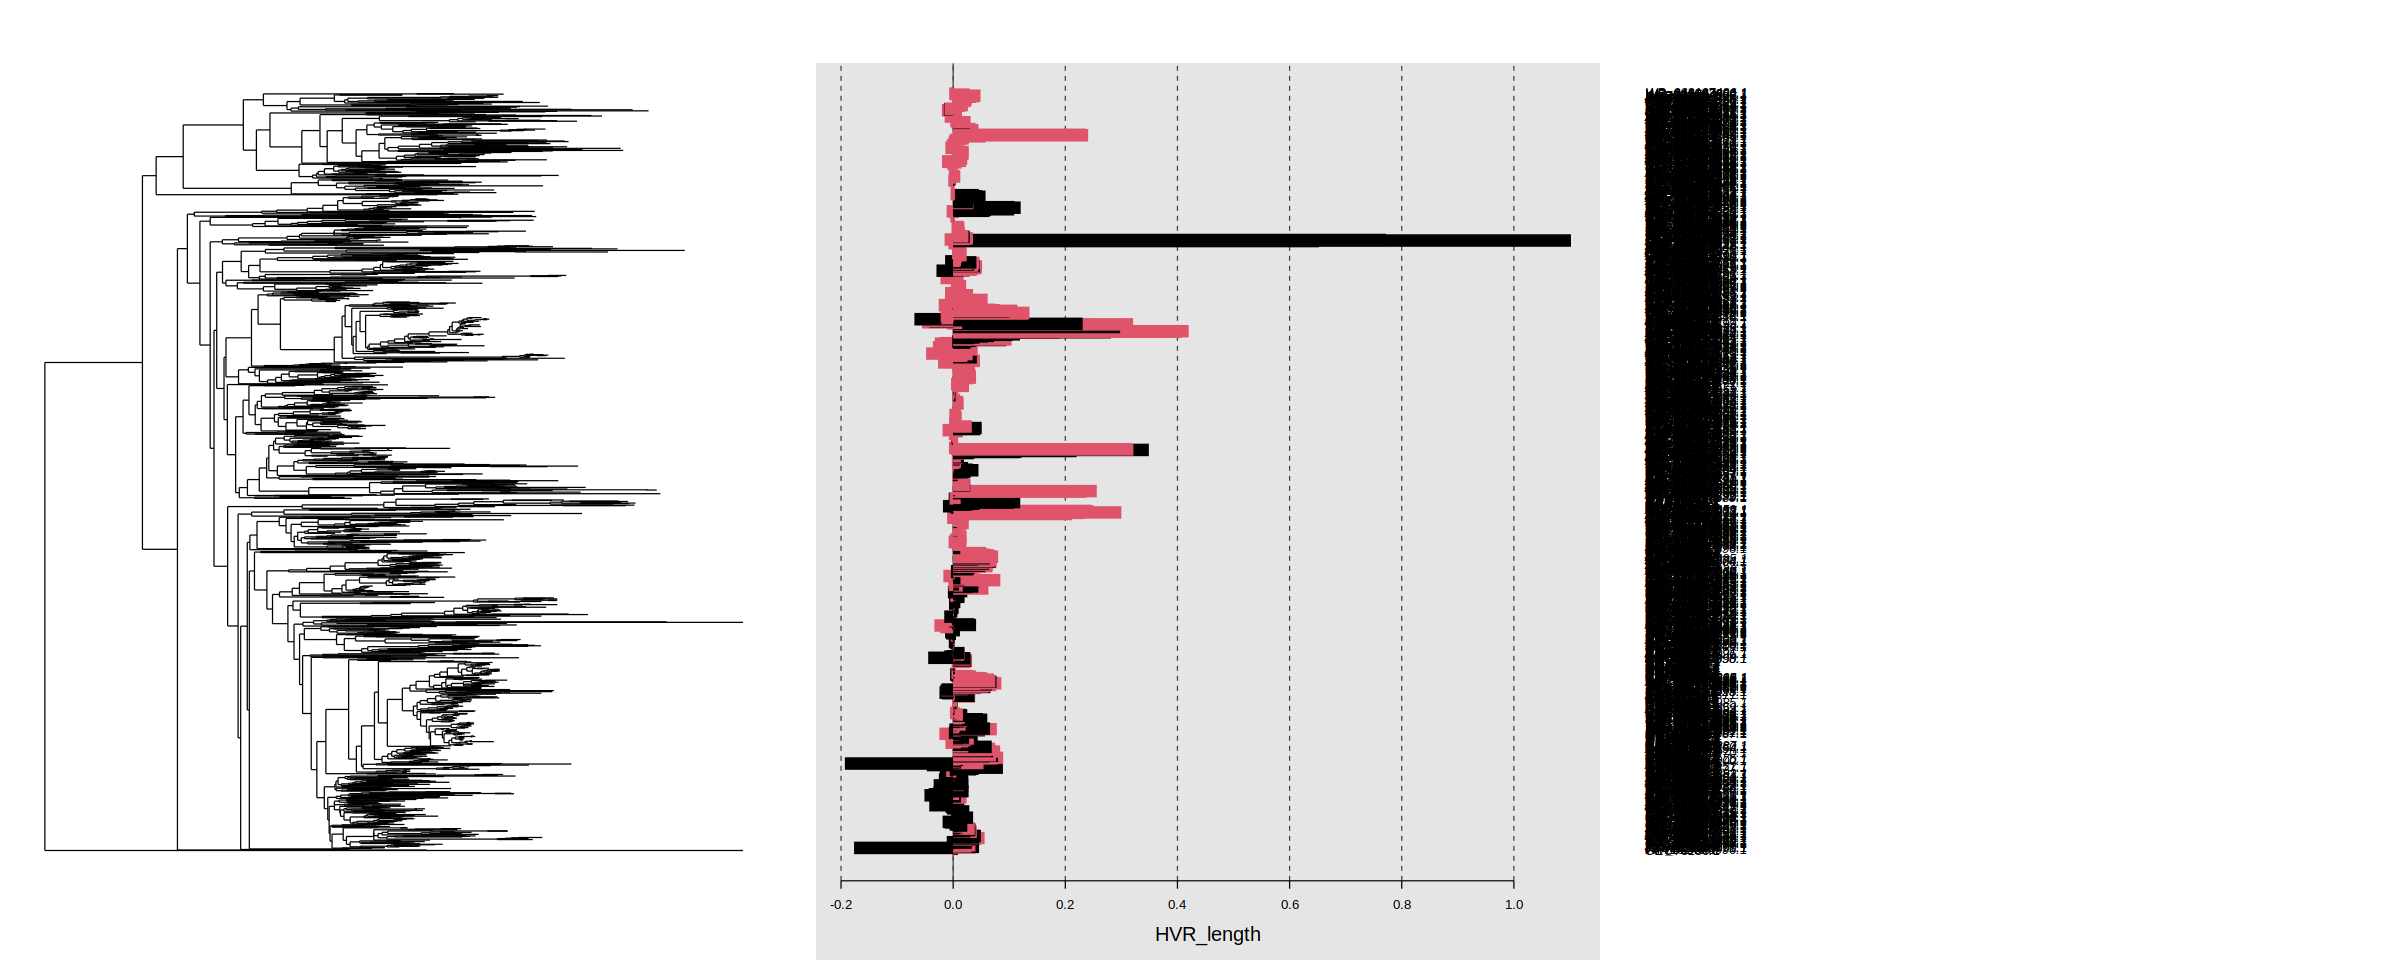

In [150]:
barplot.phylo4d(flag.lipa.p4d, trait = "HVR_length",bar.col=(flag.lipa$p.value < 0.05) + 1, center = FALSE , scale = FALSE,label.type=T)

In [153]:
host.env.dat = map.DA.host.env %>% 
select(Accession,HVR_length,genome_size)
rownames(host.env.dat) = host.env.dat$Accession
head(host.env.dat)

Warning message:
“Setting row names on a tibble is deprecated.”


Accession,HVR_length,genome_size
<chr>,<dbl>,<dbl>
OUT94870.1,431,1652246
EEJ52905.1,271,2435166
KQT19785.1,329,4456718
KDR32911.1,186,7666841
WP_095416232.1,801,4810751
OAS88434.1,266,5876049


In [ ]:
phy.host.env = prune.sample(,phy)
prunedphy <- prune.sample(comm, phy)
p4d <- phylobase::phylo4d(phy, dat)

In [182]:
comm

,AAG34566.1,AAK24938.1,AAP77961.1,AAR10729.1,AAT06254.1,AAW75835.1,ABA48561.1,ABD33704.3,ABF12111.1,ABJ81339.1,⋯,WP_118183865.1,WP_118202691.1,WP_118203859.1,WP_118280384.1,WP_118508201.1,WP_118558985.1,WP_118558987.1,WP_118680381.1,WP_118680383.1,WP_118710912.1
enriched.animals,1,0,1,0,1,0,0,1,0,0,⋯,0,0,0,1,1,1,0,1,1,0
enriched.plants,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
enriched.env,1,0,0,0,0,0,0,0,1,1,⋯,0,0,1,0,0,0,0,0,0,0
enriched.host,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0


### Using SES of MPD (Mean Pairwise Distance) and MNTD (Mean Nearest Taxon Distance) implemented in Picante

##### Phylogeny

In [8]:
phy


Phylogenetic tree with 1263 tips and 1255 internal nodes.

Tip labels:
  WP_055168195.1, WP_118109900.1, CDF42918.1, WP_118587311.1, OKZ71715.1, WP_016287750.1, ...
Node labels:
  Root, 0.627, 0.893, 0.333, 0.953, 0.907, ...

Rooted; includes branch lengths.


Phylogenetic tree with 1263 tips and 1255 internal nodes.

Tip labels:
  WP_055168195.1, WP_118109900.1, CDF42918.1, WP_118587311.1, OKZ71715.1, WP_016287750.1, ...
Node labels:
  Root, 0.627, 0.893, 0.333, 0.953, 0.907, ...

Rooted; includes branch lengths.

##### Community data

In [56]:
all.flas=rep(1,nrow(traits.enriched))
enriched.plants =rep(if_else(traits.enriched$enriched.plants==1,1,0))
enriched.env =rep(if_else(traits.enriched$enriched.env==1,1,0))
enriched.host = rep(if_else(traits.enriched$enriched.host==1,1,0))


comm.data=traits.enriched %>%
  select(Accession,enriched.animals)%>%
  mutate(Sample="enriched.animals")%>%
  distinct(Accession,.keep_all=T)%>%
  spread(Accession,enriched.animals)%>%
  column_to_rownames(var= "Sample")%>%
  rbind(enriched.plants)%>%
  rbind(enriched.env)%>%
  rbind(enriched.host)
  
row.names(comm.data) <- c("enriched.animals","enriched.plants","enriched.env","enriched.host")

comm=as.matrix(comm.data[1:nrow(comm.data),2:ncol(comm.data)])

comm.data

,AAA62844.1,AAG34566.1,AAK24938.1,AAP77961.1,AAR10729.1,AAT06254.1,AAW75835.1,ABA48561.1,ABD33704.3,ABF12111.1,⋯,WP_118183865.1,WP_118202691.1,WP_118203859.1,WP_118280384.1,WP_118508201.1,WP_118558985.1,WP_118558987.1,WP_118680381.1,WP_118680383.1,WP_118710912.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,0,1,0,1,0,1,0,0,1,0,⋯,0,0,0,1,1,1,0,1,1,0
enriched.plants,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
enriched.env,1,1,0,0,0,0,0,0,0,1,⋯,0,0,1,0,0,0,0,0,0,0
enriched.host,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0


##### Trait data

In [57]:
traits= dat
head(traits)

,enriched.animals,enriched.plants,enriched.env,enriched.host
,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,1,0
KJS48310.1,0,0,1,0
OBW58796.1,0,0,0,0
ESU34160.1,0,0,0,0
KMY55506.1,0,0,0,0
WP_087615600.1,0,0,0,0


##### Root phylogeny by midpoint

In [58]:
prunedphy <- prune.sample(comm, phy)
rooted.prunedphy=midpoint.root(prunedphy)

##### Plot distribution of selected taxa in each dataset across the phylogeny of top abundant (n=1263)

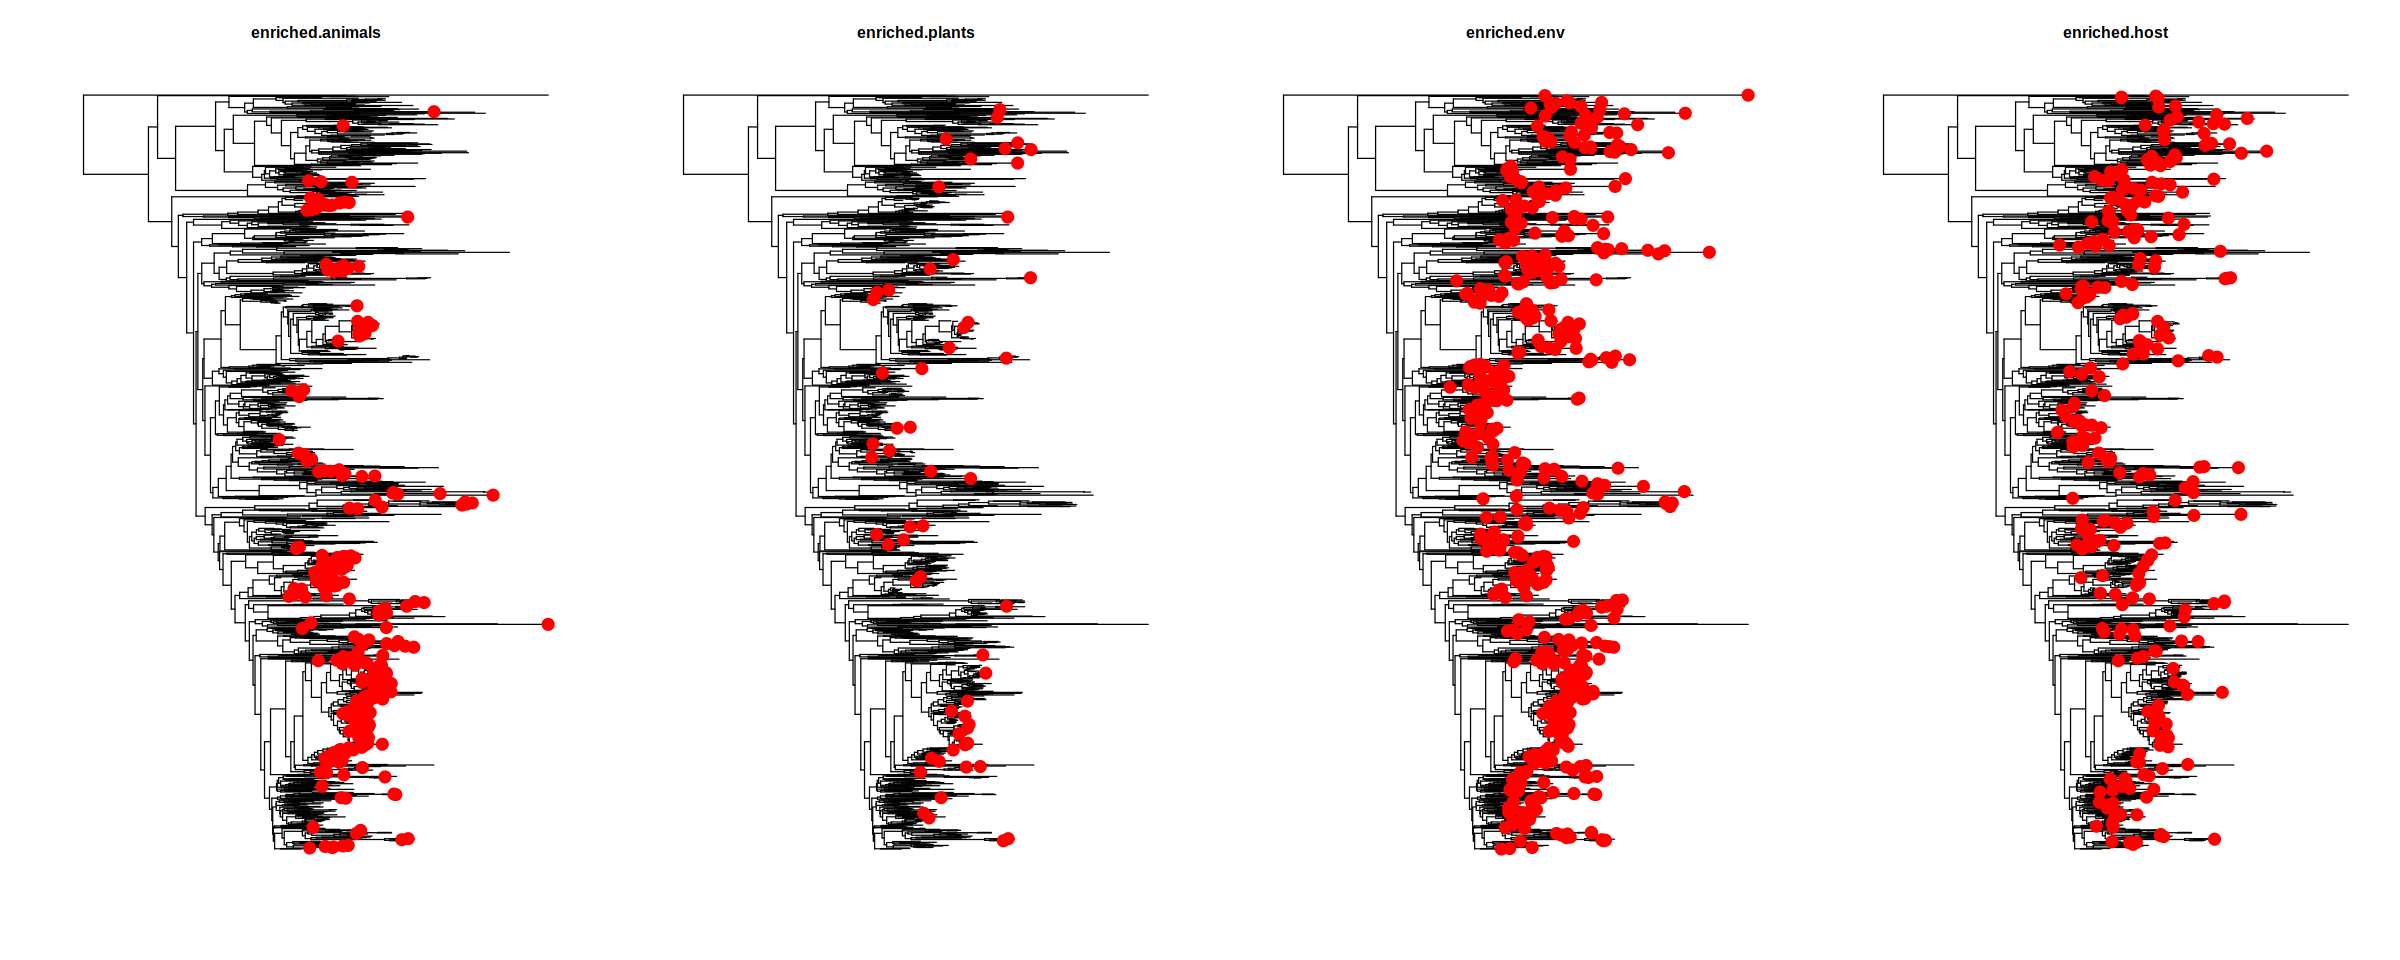

In [64]:
options(repr.plot.width=20,repr.plot.height=8)
par(mfrow = c(1, 4))
for (i in row.names(comm)) {plot(phy, show.tip.label = FALSE, main = i)
  tiplabels(tip = which(phy$tip.label %in% names(which(comm [i, ] > 0))),
pch=19, cex=2,col="red")
}

##### Calculate phylogenetic diversity

In [60]:
#pd
phy.div=pd(comm,phy,include.root=TRUE)
phy.div

,PD,SR
,<dbl>,<dbl>
enriched.animals,69.97723,294
enriched.plants,33.56630,59
enriched.env,183.93248,532
enriched.host,113.90968,284


##### Calculate null models of community assembly

In [61]:
#Create phylogeny distance matrix (MDP and MNTD require a matrix as input)
phydist=cophenetic.phylo(phy)
#phydist

#Using MDP measure (MEAN PAIRWISE DISTANCE)
ses.mpd.result <- ses.mpd(comm, phydist, null.model="taxa.labels", abundance.weighted=FALSE, runs=1000)



#Using standardized effect size of phylogenetic diversity (Faith's PD)
ses.pd <- ses.pd(samp = comm, 
                        tree = phy, 
                        null.model = "taxa.labels", 
                        runs = 1000)


#Using MNTD measure (MEAN NEAREST TAXON DISTANCE)
ses.mntd.result <- ses.mntd(comm, phydist, null.model="taxa.labels",abundance.weighted=FALSE, runs=1000)


,OEU73186.1,WP_018305791.1,KJS48310.1,OBW58796.1,ESU34160.1,KMY55506.1,WP_087615600.1,WP_039042127.1,PTY75990.1,PGK31169.1,⋯,EMT52255.1,KQL46527.1,AKP76066.1,RDW20767.1,PLR90813.1,WP_055738703.1,WP_068777453.1,EPR26812.1,PIC98532.1,PID08009.1
OEU73186.1,0.000000,4.9416022,5.0017887,5.0212303,5.0169858,5.0482504,5.01980153,5.03236128,5.0599759,5.08461909,⋯,5.595149,5.592248,5.2086962,5.2337389,5.3453582,5.3701757,5.3528488,5.2204330,5.1145046,5.1084469
WP_018305791.1,4.941602,0.0000000,0.3539132,0.4950399,0.4907954,0.5220600,0.49361114,0.50617089,0.5337855,0.55842870,⋯,1.041059,1.038159,0.6546064,0.6796490,0.7912683,0.8160858,0.7987590,0.6663431,0.5604147,0.5543571
KJS48310.1,5.001789,0.3539132,0.0000000,0.5552264,0.5509819,0.5822465,0.55379764,0.56635738,0.5939720,0.61861520,⋯,1.101246,1.098345,0.7147929,0.7398355,0.8514548,0.8762723,0.8589455,0.7265296,0.6206012,0.6145436
OBW58796.1,5.021230,0.4950399,0.5552264,0.0000000,0.3412097,0.3724743,0.34402543,0.35658518,0.3841998,0.40884299,⋯,1.148587,1.145686,0.7621340,0.7871766,0.8987959,0.9236134,0.9062865,0.7738707,0.6679423,0.6618846
ESU34160.1,5.016986,0.4907954,0.5509819,0.3412097,0.0000000,0.2369966,0.30067570,0.31323544,0.3408501,0.36549326,⋯,1.144342,1.141442,0.7578895,0.7829321,0.8945514,0.9193689,0.9020421,0.7696262,0.6636978,0.6576401
KMY55506.1,5.048250,0.5220600,0.5822465,0.3724743,0.2369966,0.0000000,0.33194022,0.34449997,0.3721146,0.39675778,⋯,1.175607,1.172706,0.7891540,0.8141967,0.9258159,0.9506334,0.9333066,0.8008907,0.6949623,0.6889047
WP_087615600.1,5.019802,0.4936111,0.5537976,0.3440254,0.3006757,0.3319402,0.00000000,0.08089198,0.1831489,0.20779205,⋯,1.147158,1.144257,0.7607052,0.7857478,0.8973671,0.9221846,0.9048577,0.7724419,0.6665135,0.6604558
WP_039042127.1,5.032361,0.5061709,0.5663574,0.3565852,0.3132354,0.3445000,0.08089198,0.00000000,0.1957086,0.22035180,⋯,1.159718,1.156817,0.7732649,0.7983076,0.9099268,0.9347444,0.9174175,0.7850016,0.6790732,0.6730156
PTY75990.1,5.059976,0.5337855,0.5939720,0.3841998,0.3408501,0.3721146,0.18314886,0.19570861,0.0000000,0.21261540,⋯,1.187332,1.184432,0.8008796,0.8259222,0.9375415,0.9623590,0.9450321,0.8126163,0.7066879,0.7006302
PGK31169.1,5.084619,0.5584287,0.6186152,0.4088430,0.3654933,0.3967578,0.20779205,0.22035180,0.2126154,0.00000000,⋯,1.211976,1.209075,0.8255227,0.8505654,0.9621847,0.9870022,0.9696753,0.8372595,0.7313311,0.7252734


,ntaxa,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,1.761845,2.110132,0.04527551,1,-7.6926007,0.000999001,1000
enriched.plants,59,2.135414,2.107251,0.11015518,603,0.2556605,0.602397602,1000
enriched.env,532,2.098695,2.111496,0.02905461,317,-0.4405897,0.316683317,1000
enriched.host,284,2.145751,2.110493,0.04583167,775,0.7692820,0.774225774,1000


,ntaxa,pd.obs,pd.rand.mean,pd.rand.sd,pd.obs.rank,pd.obs.z,pd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,69.97723,120.44341,4.066205,1,-12.4111255,0.000999001,1000
enriched.plants,59,33.56630,36.68813,2.492304,113,-1.2525855,0.112887113,1000
enriched.env,532,183.93248,184.80378,4.452746,427,-0.1956754,0.426573427,1000
enriched.host,284,113.90968,117.31661,3.978202,202,-0.8563990,0.201798202,1000


,ntaxa,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,0.2704258,0.5342963,0.02472294,1,-10.673104,0.000999001,1000
enriched.plants,59,0.7347878,0.8363158,0.07378166,79,-1.376060,0.078921079,1000
enriched.env,532,0.4376295,0.4508737,0.01420807,174,-0.932161,0.173826174,1000
enriched.host,284,0.5054270,0.5401550,0.02504932,88,-1.386384,0.087912088,1000


In [96]:
ses.mpd.result
ses.pd
ses.mntd.result

,ntaxa,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,1.761845,2.110132,0.04527551,1,-7.6926007,0.000999001,1000
enriched.plants,59,2.135414,2.107251,0.11015518,603,0.2556605,0.602397602,1000
enriched.env,532,2.098695,2.111496,0.02905461,317,-0.4405897,0.316683317,1000
enriched.host,284,2.145751,2.110493,0.04583167,775,0.7692820,0.774225774,1000


,ntaxa,pd.obs,pd.rand.mean,pd.rand.sd,pd.obs.rank,pd.obs.z,pd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,69.97723,120.44341,4.066205,1,-12.4111255,0.000999001,1000
enriched.plants,59,33.56630,36.68813,2.492304,113,-1.2525855,0.112887113,1000
enriched.env,532,183.93248,184.80378,4.452746,427,-0.1956754,0.426573427,1000
enriched.host,284,113.90968,117.31661,3.978202,202,-0.8563990,0.201798202,1000


,ntaxa,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,294,0.2704258,0.5342963,0.02472294,1,-10.673104,0.000999001,1000
enriched.plants,59,0.7347878,0.8363158,0.07378166,79,-1.376060,0.078921079,1000
enriched.env,532,0.4376295,0.4508737,0.01420807,174,-0.932161,0.173826174,1000
enriched.host,284,0.5054270,0.5401550,0.02504932,88,-1.386384,0.087912088,1000


## Vertebrates samples

In [101]:
metadataAll = read_tsv("mappingMetadataAll.txt",col_names=T)%>%
filter(category=="Animal")

Rows: 852 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): Sample, Dataset, biome_0, biome_1, biome_2, biome_3, biome_4, fami...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [174]:
head(metadataAll)

Sample,Dataset,biome_0,biome_1,biome_2,biome_3,biome_4,family,category,mammals
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRS429584,MGYS00000562,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia
ERS1065342,MGYS00000631,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia
ERS1065341,MGYS00000631,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia
ERS1065340,MGYS00000631,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia
ERS606326,MGYS00001193,root,Host-associated,Mammalia,Digestive system,Large intestine,Muridae,Animal,Mammalia
ERS606420,MGYS00001193,root,Host-associated,Mammalia,Digestive system,Large intestine,Muridae,Animal,Mammalia
